In [2]:
from email.utils import format_datetime
from itertools import count
from sys import displayhook
import xml.etree.ElementTree as ET
import pandas as pd
import glob # Библиотека для получения списка файлов
import os
import stat
from os import listdir # Библиотека для получения списка файлов
from os.path import isfile, join
from pathlib import Path


# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from datetime import date, datetime, time
#import plotly.express as px

# Библиотеки для визуализации
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import plotly.graph_objects as go


from librosa import get_duration  #  pip install librosa ## библ для рассчета продолжительности записи


In [5]:
# Обозначаем путь нахождения XML файлов 

#path = '/Users/ekaterina/github_repos/parsing_XML/AIFD_XML_full/20220426_gran_entire_day/xml'
path = '/Users/ekaterina/data4repos/AIFD_XML_full/20220426_gran_entire_day/'
#/Users/ekaterina/data4repos/AIFD_XML_full/20220426_gran_entire_day

"""
# Еще можно так получить список файлов, но в данном случае нельзя указать расширение файла (например xml)
list_of_files=os.listdir(path)
print('Список всех файлов: ',len(list_of_files))
# print('Список всех файлов: ',list_of_files) список всех файлов - работает
"""
# Получаем список файлов
list_of_files = glob.glob(path+ '/*.xml')
df_flist = pd.DataFrame(list_of_files)
# print('\nСписок всех файлов:\n',list_of_files)

# Визуализация таблицы со списком файлов
"""
fig = go.Figure(data=[go.Table(
    #header=dict(values=list(df_flist.columns),
    #            fill_color='paleturquoise',
    #            align='right'),
    cells=dict(values=[df_flist],
               fill_color='lavender',
               align='right'),)
])
fig.update_layout(width=1000, height=500)
fig.show()
"""
df_flist

0
0      /Users/ekaterina/data4repos/AIFD_XML_full/2022...
1      /Users/ekaterina/data4repos/AIFD_XML_full/2022...
2      /Users/ekaterina/data4repos/AIFD_XML_full/2022...
3      /Users/ekaterina/data4repos/AIFD_XML_full/2022...
4      /Users/ekaterina/data4repos/AIFD_XML_full/2022...
...                                                  ...
17691  /Users/ekaterina/data4repos/AIFD_XML_full/2022...
17692  /Users/ekaterina/data4repos/AIFD_XML_full/2022...
17693  /Users/ekaterina/data4repos/AIFD_XML_full/2022...
17694  /Users/ekaterina/data4repos/AIFD_XML_full/2022...
17695  /Users/ekaterina/data4repos/AIFD_XML_full/2022...

[17696 rows x 1 columns]

In [6]:
# Чтение первого файла 

file_path_file1 = os.path.join(path, list_of_files[0])
tree = ET.parse(file_path_file1)
root = tree.getroot()

print('Чтение первого файла:')
print(root.tag, root.attrib)

print('\nПуть к 1-му файлу:')
print(file_path_file1)
print()

Чтение первого файла:
analysisTask {'cc-task': '7_1_7_1645875244_3864119'}

Путь к 1-му файлу:
/Users/ekaterina/data4repos/AIFD_XML_full/20220426_gran_entire_day/node_7_domain_1_nauss_7_1645875244_3864119.xml



In [8]:
# просмотр дочерних элементов и атрибутов
for child in root:     
    print('Дочерние элементы и атрибуты:', child.tag, child.attrib)

# просмотр всех атрибутов и элементов документа
print('\nПросмотр всех атрибутов и элементов документа:\n', ET.tostring(root, encoding='utf8').decode('utf8'))




Дочерние элементы и атрибуты: timestamp {}
Дочерние элементы и атрибуты: filename {}
Дочерние элементы и атрибуты: channel {'type': 'a', 'ccAgentID': 'harsheva', 'ccDeviceID': 'harsheva'}
Дочерние элементы и атрибуты: channel {'type': 'c', 'value': '79924236148', 'caller': 'true', 'disconnect': 'true'}

Просмотр всех атрибутов и элементов документа:
 <?xml version='1.0' encoding='utf8'?>
<analysisTask cc-task="7_1_7_1645875244_3864119"><timestamp>2022-05-05 10:27:34.000 MSK</timestamp><filename>node_7_domain_1_nauss_7_1645875244_3864119.wav</filename><channel type="a" ccAgentID="harsheva" ccDeviceID="harsheva" /><channel type="c" value="79924236148" caller="true" disconnect="true" /></analysisTask>


In [11]:
# ФОРМИРОВАНИЕ РАБОЧЕГО ДАТА-ФРЕЙМА

# инициализируем два пустых фрейма данных, которые будут заполнены указанными выше элементами. 
# Мы включим type,ccAgentID, ccDeviceID, timestamp, caller
df_1 = pd.DataFrame()
df = pd.DataFrame()
i=0
list_keywords=[]

for file in list_of_files:
    # file_path=path+file  - в оригинале(у нас path прописан path = '/Users/ekaterina/github_repos/parsing_XML/xml' поэтому происходит дублирование - path+path+file - выдает ошибку. В связи с этим надо оставить file_path=file)
    # print("Директория:\n", path)
    # print('Файл:\n', file)
    # print('Путь к файлу:\n'+file_path)
    # print('~'*40)
    tree = ET.parse(file)
    #tree = ET.parse(path+file)
    root = tree.getroot()
# Формируем колонки:
    trial = {}

    # trial['type'] = root.find('channel').text         # не требуется для анализа
    trial['ccAgentID'] = root.find('channel').text 
    # trial['ccDeviceID'] = root.find('channel').text   # не требуется для анализа
    trial['filename'] = root.find('filename').text

# Переводим строковое значение времени в datestamp
    date_string = root.find('timestamp').text
    format_datetime = pd.to_datetime(date_string)
    format_date = pd.to_datetime(date_string).date()
    format_time = pd.to_datetime(date_string).time()
    # print(format_time) # проверка 

    """
    if root.find('channel') != None:
        trial['type'] = tree.find('channel').get('type')
    else:
        trial['type'] = ''
    """
        
    if root.find('channel') != None:
        trial['ccAgentID'] = tree.find('channel').get('ccAgentID')
    else:
        trial['ccAgentID'] = ''
    '''
    if root.find('channel') != None:
        trial['ccDeviceID'] = tree.find('channel').get('ccDeviceID')
    else:
        trial['ccDeviceID'] = ''
    '''
    if root.find('timestamp') != None:
        trial['datetime'] = format_datetime    
    else:
        trial['datetime'] = ''

    if root.find('timestamp') != None:
        trial['date'] = format_date   
    else:
        trial['date'] = ''

    if root.find('timestamp') != None:
        trial['time'] = format_time   
    else:
        trial['time'] = ''
    """
    if root.find('filename') != None:
        trial['filename'] = tree.find('channel').get('filename')
    else:
        trial['filename'] = ''
    """
    df = pd.DataFrame(trial,index=[i]) # i-ая строка из df...
    i=i+1

    df_1 = pd.concat([df_1, df])       # ...присоединяется к df_1 


In [13]:
df_1

ccAgentID                                        filename  \
0             harsheva  node_7_domain_1_nauss_7_1645875244_3864119.wav   
1           vlasovaoza  node_8_domain_3_nauss_8_1645876859_4163178.wav   
2      lobanova_ea_ksm  node_7_domain_3_nauss_7_1645875244_3835263.wav   
3            Elena_OP1  node_7_domain_0_nauss_7_1645875244_4209694.wav   
4      kulikova_eu_ksm  node_7_domain_3_nauss_7_1645875244_3683286.wav   
...                ...                                             ...   
17691        kostinaoz  node_8_domain_5_nauss_8_1645876859_4414241.wav   
17692    semenistayaoz  node_7_domain_1_nauss_7_1645875244_3476827.wav   
17693    semenistayaoz  node_7_domain_4_nauss_7_1645875244_3739774.wav   
17694         harsheva  node_7_domain_2_nauss_7_1645875244_3903386.wav   
17695        kostinaoz  node_7_domain_5_nauss_7_1645875244_3475188.wav   

                       datetime        date      time  
0     2022-05-05 10:27:34+03:00  2022-05-05  10:27:34  
1     2022-04-30 18:01:11+03:00  2022-04-30  18:01:11  
2     2022-05-04 15:05:34+03:00  2022-05-04  15:05:34  
3     2022-05-13 12:16:28+03:00  2022-05-13  12:16:28  
4     2022-04-29 14:26:23+03:00  2022-04-29  14:26:23  
...                         ...         ...       ...  
17691 2022-05-07 09:42:01+03:00  2022-05-07  09:42:01  
17692 2022-04-27 15:31:44+03:00  2022-04-27  15:31:44  
17693 2022-05-01 11:09:33+03:00  2022-05-01  11:09:33  
17694 2022-05-05 19:37:02+03:00  2022-05-05  19:37:02  
17695 2022-04-27 15:25:08+03:00  2022-04-27  15:25:08  

[17696 rows x 5 columns]

In [8]:

# Визуализация полученного дата-фрейма 
"""
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_1.columns),
                fill_color='paleturquoise',
                align='right'),
    cells=dict(values=df_1,
               fill_color='lavender',
               align='right'),)
])
fig.update_layout(width=1000, height=500)
fig.show()

In [171]:
# Отсортируем по агентам
df_sort = df_1.sort_values(by=['ccAgentID','datetime'])
df_sort

type     ccAgentID    ccDeviceID                  datetime        date  \
17067    a  Ekaterina_OP  Ekaterina_OP 2022-05-05 10:20:00+03:00  2022-05-05   
4288     a  Ekaterina_OP  Ekaterina_OP 2022-05-05 10:24:00+03:00  2022-05-05   
13404    a  Ekaterina_OP  Ekaterina_OP 2022-05-05 10:26:00+03:00  2022-05-05   
12153    a  Ekaterina_OP  Ekaterina_OP 2022-05-05 10:33:00+03:00  2022-05-05   
8820     a  Ekaterina_OP  Ekaterina_OP 2022-05-05 10:50:00+03:00  2022-05-05   
...    ...           ...           ...                       ...         ...   
11519    a    vlasovaoza    vlasovaoza 2022-05-15 19:44:00+03:00  2022-05-15   
17354    a    vlasovaoza    vlasovaoza 2022-05-15 19:44:00+03:00  2022-05-15   
2944     a    vlasovaoza    vlasovaoza 2022-05-15 19:59:00+03:00  2022-05-15   
4233     a    vlasovaoza    vlasovaoza 2022-05-15 20:15:00+03:00  2022-05-15   
5054     a    vlasovaoza    vlasovaoza 2022-05-15 20:42:00+03:00  2022-05-15   

           time  hour  Calls Qty  
17067  10:19:53    10        NaN  
4288   10:23:34    10        NaN  
13404  10:26:18    10        NaN  
12153  10:32:45    10        NaN  
8820   10:50:24    10        NaN  
...         ...   ...        ...  
11519  19:43:44    19        NaN  
17354  19:44:27    19        NaN  
2944   19:59:00    19        NaN  
4233   20:15:03    20        NaN  
5054   20:41:39    20        NaN  

[17696 rows x 8 columns]

In [180]:
df_sort['time'].iloc[428817067] - df_sort['time'].iloc[17067]

IndexError: single positional indexer is out-of-bounds

In [177]:

numbers = df_sort['time']
i=0
for value in numbers:
    i = i[1]-i[0]
print("Сумма равна", i)



TypeError: 'int' object is not subscriptable

In [163]:
m=df_1.time
x=df_1.datetime[0+1]

In [159]:
sum([(x-m) for X in df_1.datetime])
#df_agent=df_1[['ccAgentID'],['datetime']]

TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'

In [ ]:
# Itertuples
total = []
for row in df_1.itertuples():
    total.append(row[1] - row[0])

In [142]:

df_1['time_between_calls']=[]


In [144]:

def summary(x):
    result = {
        'time_between_calls': x['time'] - x['time']
    }
    return pd.Series(result).round(0)

In [145]:
df_1.groupby(['ccAgentID']).apply(summary)

TypeError: unsupported operand type(s) for -: 'datetime.time' and 'datetime.time'

In [51]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17696 entries, 0 to 17695
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype                                
---  ------      --------------  -----                                
 0   type        17696 non-null  object                               
 1   ccAgentID   17696 non-null  object                               
 2   ccDeviceID  17696 non-null  object                               
 3   datetime    17696 non-null  datetime64[ns, pytz.FixedOffset(180)]
 4   date        17696 non-null  object                               
 5   time        17696 non-null  object                               
dtypes: datetime64[ns, pytz.FixedOffset(180)](1), object(5)
memory usage: 967.8+ KB


In [68]:
df_1.to_csv('gran_for_analize.csv')
df_1.to_pickle('gran_for_analize.pkl')

In [53]:
print('Кол-во записей\n',len(df_1))

print('Кол-во уникальных агентов\n', len(df_1['ccAgentID'].unique()))

print('Кол-во дней с записями\n', len(df_1['date'].unique()))
print('Уникальные даты\n', (df_1['date'].unique()))


Кол-во записей
 17696
Кол-во уникальных агентов
 37
Кол-во дней с записями
 22
Уникальные даты
 [datetime.date(2022, 5, 5) datetime.date(2022, 4, 30)
 datetime.date(2022, 5, 4) datetime.date(2022, 5, 13)
 datetime.date(2022, 4, 29) datetime.date(2022, 4, 27)
 datetime.date(2022, 5, 16) datetime.date(2022, 5, 14)
 datetime.date(2022, 5, 7) datetime.date(2022, 5, 11)
 datetime.date(2022, 5, 17) datetime.date(2022, 5, 6)
 datetime.date(2022, 4, 28) datetime.date(2022, 5, 8)
 datetime.date(2022, 5, 2) datetime.date(2022, 5, 1)
 datetime.date(2022, 5, 3) datetime.date(2022, 5, 12)
 datetime.date(2022, 5, 18) datetime.date(2022, 5, 10)
 datetime.date(2022, 5, 9) datetime.date(2022, 5, 15)]


In [96]:
# Округляем до часов. С помощью функции df_1['hour'] = df_1['datetime'].dt.hour получаем данные в нужном формате INT

df_1['hour'] = df_1['datetime'].dt.hour
print("Округление hours function:/n", df_1['hour'])
df_1.info()

# Округляем datetime до минут - просто для тренировки
df_1['datetime'] = df_1['datetime'].dt.round('min')
print("Округление минуты:/n", df_1['datetime'])



Округление hours function:/n 0        10
1        18
2        15
3        12
4        14
         ..
17691     9
17692    15
17693    11
17694    19
17695    15
Name: hour, Length: 17696, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17696 entries, 0 to 17695
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype                                
---  ------      --------------  -----                                
 0   type        17696 non-null  object                               
 1   ccAgentID   17696 non-null  object                               
 2   ccDeviceID  17696 non-null  object                               
 3   datetime    17696 non-null  datetime64[ns, pytz.FixedOffset(180)]
 4   date        17696 non-null  object                               
 5   time        17696 non-null  object                               
 6   hour        17696 non-null  int64                                
 7   Calls Qty   0 non-null      float64            

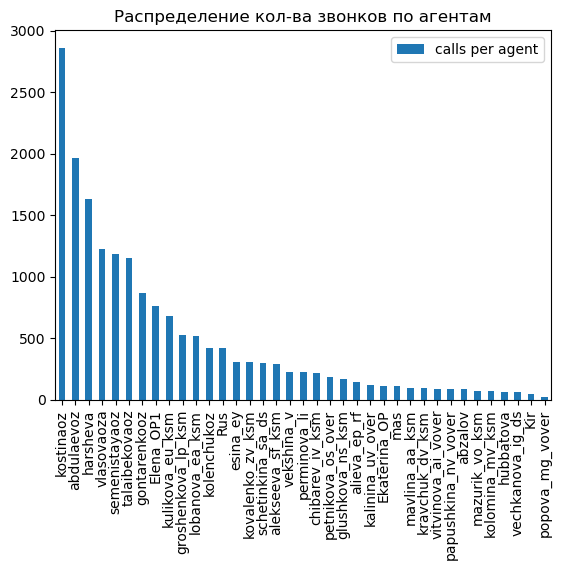

In [109]:
df_1['ccAgentID'].value_counts().plot(kind='bar', label='calls per agent')
plt.legend()
plt.title('Распределение кол-ва звонков по агентам')
plt.show()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17696 entries, 0 to 17695
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype                                
---  ------      --------------  -----                                
 0   type        17696 non-null  object                               
 1   ccAgentID   17696 non-null  object                               
 2   ccDeviceID  17696 non-null  object                               
 3   datetime    17696 non-null  datetime64[ns, pytz.FixedOffset(180)]
 4   date        17696 non-null  datetime64[ns]                       
 5   time        17696 non-null  object                               
 6   hour        17696 non-null  int64                                
dtypes: datetime64[ns, pytz.FixedOffset(180)](1), datetime64[ns](1), int64(1), object(4)
memory usage: 1.1+ MB


Text(0, 0.5, 'Количество calls')

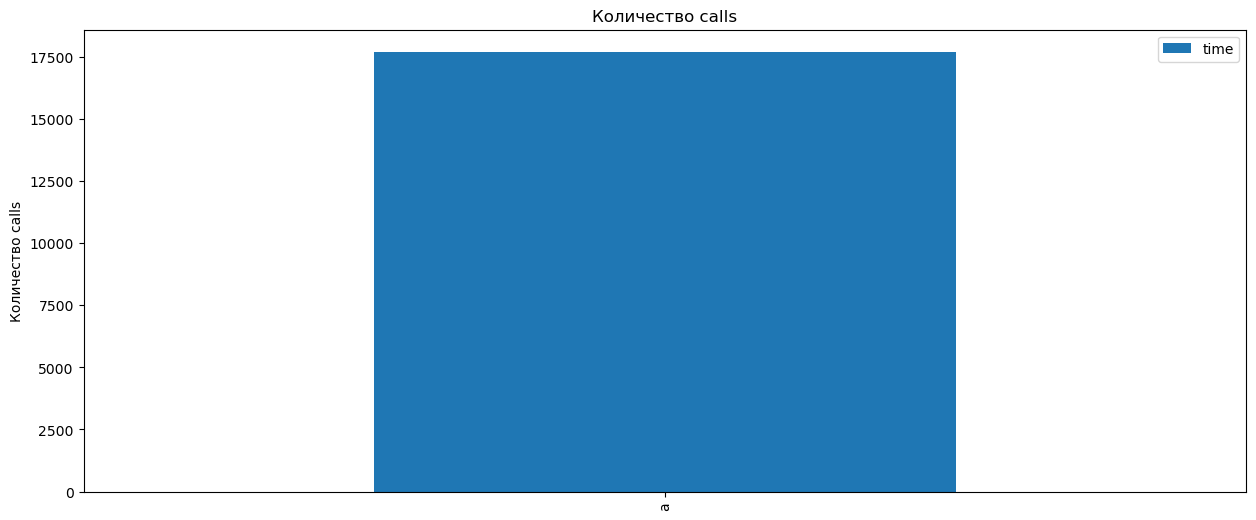

In [11]:
df.datetime = pd.to_numeric(df.datetime, errors='coerce').fillna(0).astype(np.int64)
df.time = pd.to_numeric(df.time, errors='coerce').fillna(0).astype(np.int64)
df_1.info()
df_1['type'].value_counts().plot(kind='bar', label='time', figsize = (15,6), title = 'Количество calls')
plt.legend()
plt.ylabel('Количество calls')
# plt.show()

Text(0.5, 0, 'Время звонка (час)')

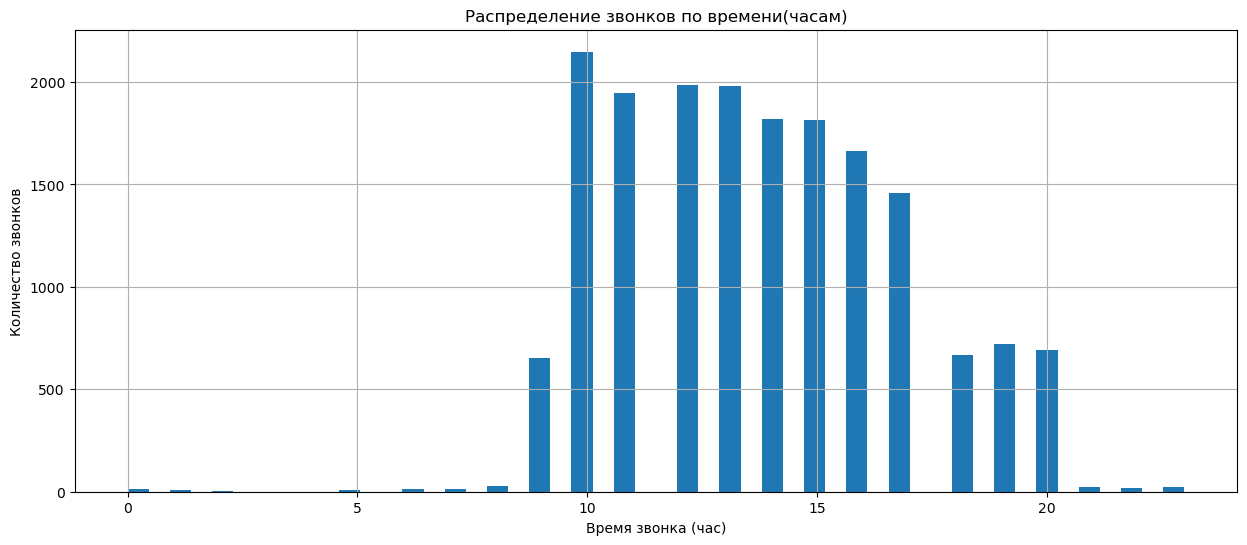

In [12]:
#Построение графика "Распределение звонков по часам"

df_1['hour'].hist(bins=50, figsize = (15,6))
plt.title('Распределение звонков по времени(часам)')
plt.ylabel('Количество звонков')
plt.xlabel('Время звонка (час)')
# plt.show()

Text(0, 0.5, 'dispercia calls in time')

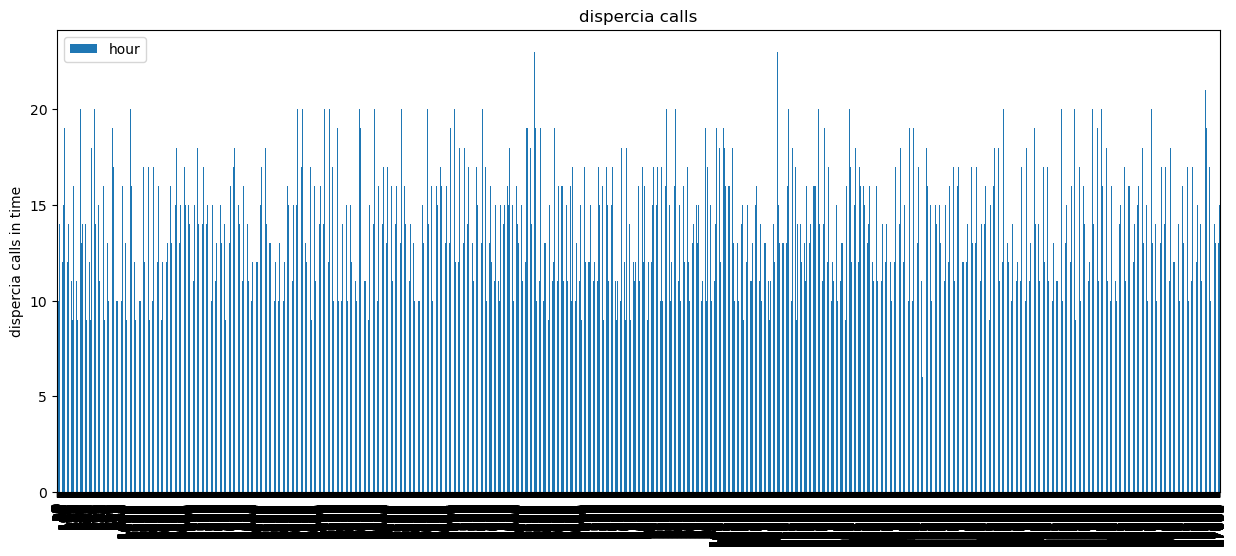

In [13]:
# Распределение звонков во времени
import plotly.express as px
df_1['hour'].plot(kind='bar', label='hour', figsize = (15,6), title = 'dispercia calls')
plt.legend()
plt.ylabel('dispercia calls in time')
# plt.show()



In [48]:
Agent_hour_min = df_1.groupby('ccAgentID')['hour'].min()
Agent_hour_max = df_1.groupby('ccAgentID')['hour'].max()
# print("Час начала рабочего дня:",Agent_hour_min)
# print("Час конца рабочего дня:", Agent_hour_max)

duration = Agent_hour_max-Agent_hour_min
print("Продолжительность рабочего дня агентов:",duration)

Продолжительность рабочего дня агентов: ccAgentID
Ekaterina_OP            5
Elena_OP1               8
Kir                     4
Rus                     8
abdulaevoz             10
abzalov                23
alekseeva_sf_ksm        5
alieva_ep_rf            8
chibarev_iv_ksm         7
esina_ey                6
glushkova_ns_ksm        7
gontarenkooz           10
groshenkova_lp_ksm      7
harsheva               11
hubbatova              23
kalinina_uv_over        8
kolenchukoz             4
kolomina_mv_ksm         4
kostinaoz              12
kovalenko_zv_ksm        8
kravchuk_dv_ksm         2
kulikova_eu_ksm         7
lobanova_ea_ksm         6
mas                     4
mavlina_aa_ksm          7
mazurik_vo_ksm          7
papushkina_nv_vover     7
perminova_li            4
petnikova_os_over       6
popova_mg_vover         3
schetinkina_sa_ds       7
semenistayaoz          11
talaibekovaoz          11
vechkanova_ig_ds        4
vekshina_v              6
vitvinova_ai_vover      5
vlasovaoza    

In [15]:
# Продолжительность рабочего дня datetime

Agent_date_min = df_1.groupby('ccAgentID')['datetime'].min()
Agent_date_max = df_1.groupby('ccAgentID')['datetime'].max()
print("День и час начала рабочего дня/n:",Agent_date_min)
print("День и час конца рабочего дня/n:", Agent_date_max)

duration_date = Agent_date_max-Agent_date_min
print("Продолжительность рабочего дня агентов:",duration_date)

День и час начала рабочего дня/n: ccAgentID
Ekaterina_OP          2022-05-05 10:20:00+03:00
Elena_OP1             2022-04-27 10:19:00+03:00
Kir                   2022-05-04 10:23:00+03:00
Rus                   2022-05-04 10:04:00+03:00
abdulaevoz            2022-04-27 10:01:00+03:00
abzalov               2022-04-27 06:58:00+03:00
alekseeva_sf_ksm      2022-04-27 10:00:00+03:00
alieva_ep_rf          2022-04-27 10:13:00+03:00
chibarev_iv_ksm       2022-05-12 15:59:00+03:00
esina_ey              2022-04-27 10:12:00+03:00
glushkova_ns_ksm      2022-05-12 15:21:00+03:00
gontarenkooz          2022-04-27 10:02:00+03:00
groshenkova_lp_ksm    2022-04-27 10:01:00+03:00
harsheva              2022-04-27 09:00:00+03:00
hubbatova             2022-04-28 21:48:00+03:00
kalinina_uv_over      2022-04-27 11:01:00+03:00
kolenchukoz           2022-04-27 16:23:00+03:00
kolomina_mv_ksm       2022-05-04 10:01:00+03:00
kostinaoz             2022-04-27 15:00:00+03:00
kovalenko_zv_ksm      2022-04-27 10:07:00+03

In [16]:
# saving the dataframe
df_gran = df_1
df_gran.to_csv('file1.csv')
df_gran.to_pickle('/Users/ekaterina/github_repos/FatigueDatasetAnalizeAndCleaning/data-chego-to.pkl')

In [114]:
# Продолжительность 1 записи

import librosa 
wav_dir = "/Users/ekaterina/github_repos/FatigueApps2023/iFatigue/"
wav_file = "_aLAW_2023-02-28-15-59.aac.wav"
duration = librosa.get_duration(path = wav_dir+wav_file) # в последней версии Librosa вместо filename используется зфер
print("Длительность аудиозаписи", wav_file, "=", duration, "sec")

'''
res = sum(get_duration(filename=str(f)) for f in wav_dir.rglob("*.wav"))
print(res)  
'''

Длительность аудиозаписи _aLAW_2023-02-28-15-59.aac.wav = 25.077625 sec


'\nres = sum(get_duration(filename=str(f)) for f in wav_dir.rglob("*.wav"))\nprint(res)  \n'